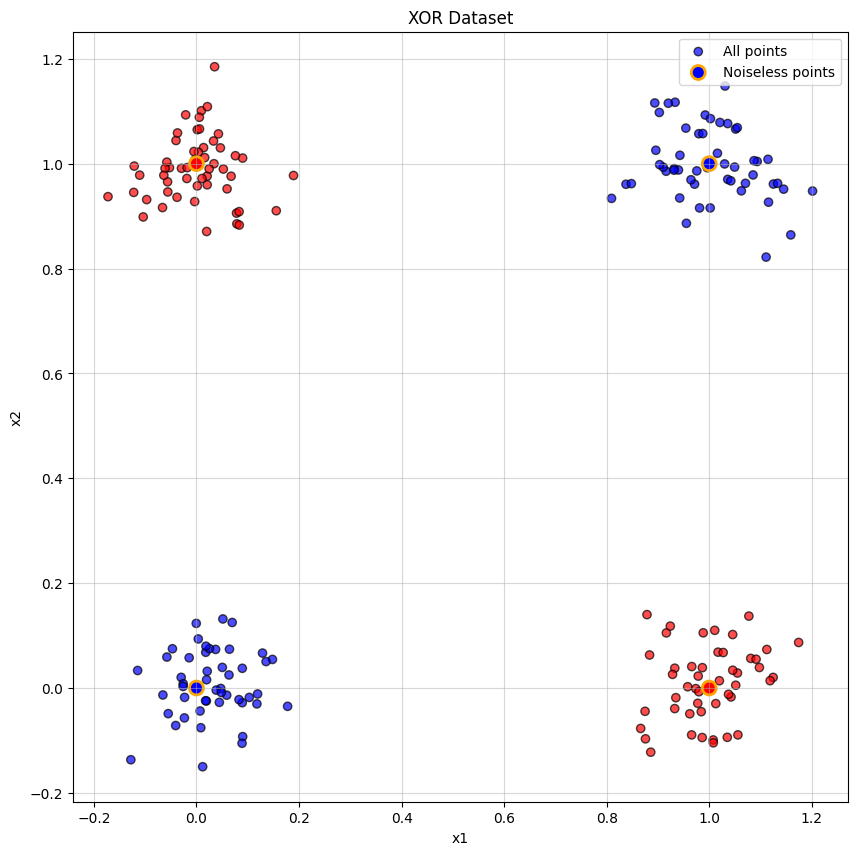

Epoch 1/150
Train Loss: 0.6889612674713135, Validation Loss: 0.16326312720775604
Train Accuracy: 0.7178, Validation Accuracy: 1.0
Epoch 2/150
Train Loss: 0.6882641315460205, Validation Loss: 0.16326312720775604
Train Accuracy: 0.7178, Validation Accuracy: 1.0
Epoch 3/150
Train Loss: 0.6875205039978027, Validation Loss: 0.16326312720775604
Train Accuracy: 0.6994, Validation Accuracy: 1.0
Epoch 4/150
Train Loss: 0.6867105960845947, Validation Loss: 0.16326312720775604
Train Accuracy: 0.6994, Validation Accuracy: 1.0
Epoch 5/150
Train Loss: 0.6858656406402588, Validation Loss: 0.16326312720775604
Train Accuracy: 0.6994, Validation Accuracy: 1.0
Epoch 6/150
Train Loss: 0.6849727630615234, Validation Loss: 0.16326312720775604
Train Accuracy: 0.6994, Validation Accuracy: 1.0
Epoch 7/150
Train Loss: 0.684029221534729, Validation Loss: 0.16326312720775604
Train Accuracy: 0.6994, Validation Accuracy: 1.0
Epoch 8/150
Train Loss: 0.6830589771270752, Validation Loss: 0.16326312720775604
Train Accu

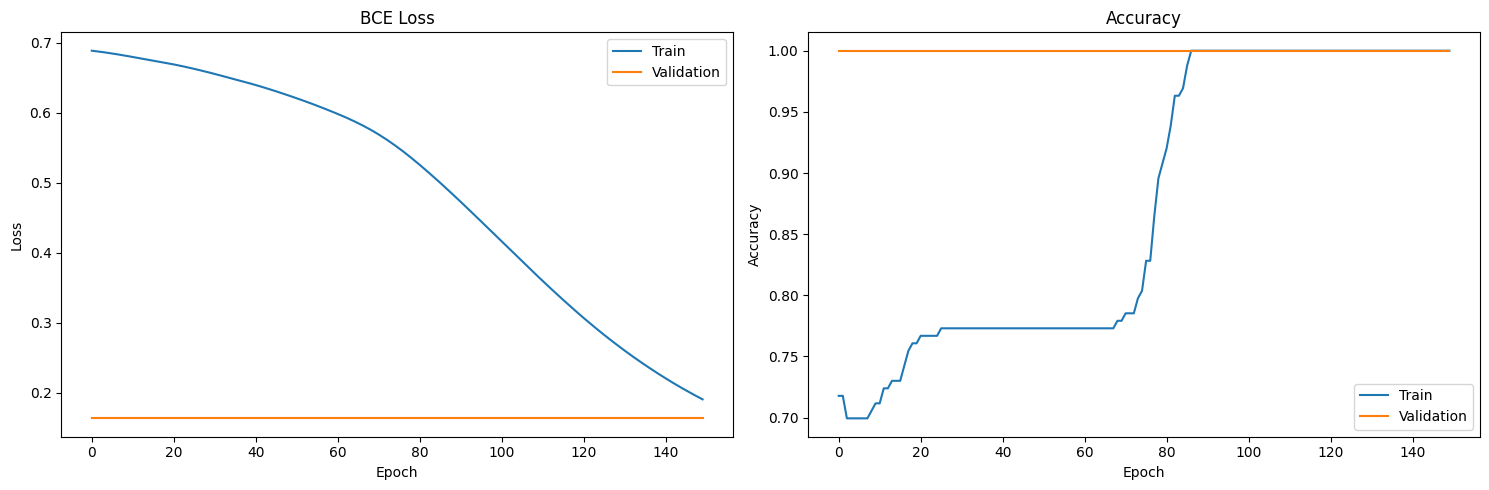

In [19]:
import numpy as npy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


stddeviation = 0.07
num_epochs = 150
lr = 0.01
test_size = 0.2


trainloss = []
valLoss = []
trainacc = []
valacc = []


def XORDataset(stddeviation, noiseless_main_points, noiseless_coreOutputLabels):
    noisyAugPoints = []
    noisyAugLabels = []

    for i in range(200):
        randNum = npy.random.randint(0, 4)
        randomPointPicked = noiseless_main_points[randNum].copy()

        Gaussiannoise = npy.random.normal(0, stddeviation, size=2)
        newrandompoint = randomPointPicked + Gaussiannoise

        noisyAugPoints.append(newrandompoint)
        noisyAugLabels.append(noiseless_coreOutputLabels[randNum])

    noisyAugPoints = npy.array(noisyAugPoints, dtype=npy.float32)
    noisyAugLabels = npy.array(noisyAugLabels, dtype=npy.float32)

    totalPoints = npy.concatenate([noiseless_main_points, noisyAugPoints], axis=0)
    totalLabels = npy.concatenate([noiseless_coreOutputLabels, noisyAugLabels], axis=0)

    return totalPoints, totalLabels


noiseless_main_points = npy.array([[0, 0], [0, 1], [1, 0], [1, 1]])
noiseless_coreOutputLabels = npy.array([0, 1, 1, 0], dtype = npy.float32)

Xpt, yLabels = XORDataset(stddeviation, noiseless_main_points, noiseless_coreOutputLabels)


Xpt_train, Xpt_valid, yLabels_train, yLabels_valid = train_test_split(
    Xpt, yLabels, test_size=test_size, random_state=42, stratify=yLabels
)

plt.figure(figsize=(10, 10))
plt.scatter(Xpt[:, 0], Xpt[:, 1], c=yLabels, cmap='bwr', alpha=0.7, edgecolors='k', label='All points')
plt.scatter(noiseless_main_points[:, 0], noiseless_main_points[:, 1],
           c=noiseless_coreOutputLabels, cmap='bwr', s=100, edgecolors='orange',
           linewidth=2, label='Noiseless points')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("XOR Dataset")
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()


Xpt_trainTen = torch.tensor(Xpt_train, dtype=torch.float32)
yLabel_trainTen = torch.tensor(yLabels_train, dtype=torch.float32).reshape(-1, 1)
Xpt_valTensor = torch.tensor(Xpt_valid, dtype=torch.float32)
yLabel_valTensor = torch.tensor(yLabels_valid, dtype=torch.float32).reshape(-1, 1)


class MLP(nn.Module):
    def __init__(self, num_input, num_hidden, activation):
        super(MLP, self).__init__()
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.activation_name = activation

        self.fc_1 = nn.Linear(self.num_input, self.num_hidden)
        self.fc_2 = nn.Linear(self.num_hidden, 1)

    def forward(self, x):
        x = self.fc_1(x)
        if self.activation_name == 'tanh':
            x = torch.tanh(x)
        elif self.activation_name == 'relu':
            x = torch.relu(x)
        x = self.fc_2(x)
        return x

# do not -> mix this and the other function. but delete Function to calculate accuracy and loss
def calculateAccuracyandLoss(modl, XtrainVal, yTrain, XptVal, yLabelVal):
    loss = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(modl.parameters(), lr=lr)


    for epoch in range(num_epochs):

        modl.train()
        optim.zero_grad()

        trainOut = modl(XtrainVal)
        trainLoss = loss(trainOut, yTrain)
        trainLoss.backward()
        optim.step()


        train_pred = (torch.sigmoid(trainOut) > 0.5).float()
        train_acc = (train_pred == yTrain).float().mean().item()
        trainloss.append(trainLoss.item())
        trainacc.append(train_acc)


        model.eval()
        with torch.no_grad():
            valOut = model(XptVal)
            val_pred = (torch.sigmoid(valOut) > 0.5).float()
            val_acc = (val_pred == yLabelVal).float().mean().item()
            valLoss_value = loss(valOut, yLabelVal)

            valLoss.append(valLoss_value.item())
            valacc.append(val_acc)


        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {trainLoss.item()}, Validation Loss: {valLoss_value.item()}")
        print(f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc}")

    return {
        'train_losses': trainloss,
        'val_losses': valLoss,
        'train_accuracies': trainacc,
        'val_accuracies': valacc
    }


modl = MLP(num_input=2, num_hidden=4, activation='relu')
modl.eval()
data = calculateAccuracyandLoss(modl, Xpt_trainTen, yLabel_trainTen, Xpt_valTensor, yLabel_valTensor)


with torch.no_grad():
    # Training accuracy
    trainOut = modl(Xpt_trainTen)
    train_pred = (torch.sigmoid(trainOut) > 0.5).float()
    train_acc = (train_pred == yLabel_trainTen).float().mean().item()
print(f"\nFinal Training Accuracy: {train_acc:.4f}")

with torch.no_grad():

    validOut = modl(Xpt_valTensor)
    valid_pred = (torch.sigmoid(validOut) > 0.5).float()
    valid_acc = (valid_pred == yLabel_valTensor).float().mean().item()
print(f"Final Validation Accuracy: {valid_acc:.4f}")
FIG, (plot1, plot2) = plt.subplots(1, 2, figsize=(15, 5))
plot1.set_xlabel('Epoch')
plot1.set_ylabel('Loss')
plot1.plot(data['train_losses'], label='Train')
plot1.plot(data['val_losses'], label='Validation')

plot1.set_title('BCE Loss')
plot1.legend()

plot2.plot(data['train_accuracies'], label='Train')
plot2.plot(data['val_accuracies'], label='Validation')
plot2.set_xlabel('Epoch')
plot2.set_ylabel('Accuracy')
plot2.set_title('Accuracy')
plot2.legend()

plt.tight_layout()
plt.show()


Implementing Fashion MNIST dataset

 Opt for one which dataset do you want MNIST, FashionMNIST: MNIST
Enter the no of hidden layers: 4
Enter no of neurons in the hidden layer 1 : 64
Enter activation you want to apply for hidden layer 1: sigmoid
Enter no of neurons in the hidden layer 2 : 128
Enter activation you want to apply for hidden layer 2: relu
Enter no of neurons in the hidden layer 3 : 256
Enter activation you want to apply for hidden layer 3: leakyrelu
Enter no of neurons in the hidden layer 4 : 512
Enter activation you want to apply for hidden layer 4: tanh
Done
Choose one of the optimizer functions out of the following.
1.SGD
2.Adam
3.AdaGrad
Adam
Epoch 0 -------------------------
Training average loss: 0.5580817364594516
Training accuracy: 92.0459976196289
Validation accuracy: 92.73999786376953
Save model to file
Epoch 1 -------------------------
Training average loss: 0.23297213385705753
Training accuracy: 94.46199798583984
Validation accuracy: 94.51000213623047
Save model to file
Epoch 2 -------------------

<Figure size 480x480 with 0 Axes>

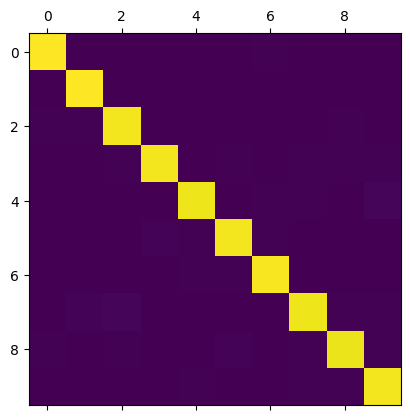

Total time taken = 168.02440309524536
Done


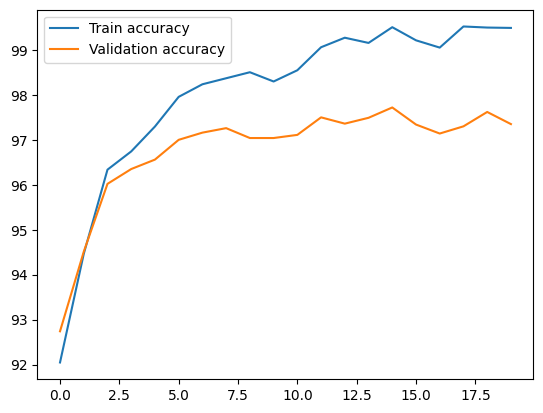

In [56]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import time
import torch.nn as nn
import torch.nn.functional as func

start_time = time.time()

# Dataset selection
DatasetSelection = input(" Opt for one which dataset do you want MNIST, FashionMNIST: ")

if DatasetSelection == "MNIST":
    # MNIST dataset loading from pickle file
    f = open('mnist.pkl', 'rb')
    dictionary = pickle.load(f)     # contains 4 different matrices
    f.close()

    X = dictionary['training_images']     # 60,000 training images 784 = 28 x 28 flatten to single vector
    y = dictionary['training_labels']     # labels 0-9
    X_test = dictionary['test_images']    # 10,000 test images
    y_test = dictionary['test_labels']
    num_labels = 10

    # print(X.shape)
    # print(y.shape)
    # print(X_test.shape)
    # print(y_test.shape)

    # Select the first 1,000 examples for both training and testing set
    num_train = 50000                                   # Train images
    num_valid = 10000                                   # We have a validation set
    num_test = 10000                                    # Test images

    X_train = torch.FloatTensor(X[:num_train, :])        # :num_train -> all data rows chosen from beginning upto but not including num_train and , : after comma -> select all columns for those rows.
    y_train_original = torch.LongTensor(y[:num_train])            # rows from 1 to num_train = train set
    X_valid = torch.FloatTensor(X[num_train:, :])        # rows from num_train to the end = validation set
    y_valid_original = torch.LongTensor(y[num_train:])
    X_test = torch.FloatTensor(X_test[:num_test, :])
    y_test_original = torch.LongTensor(y_test[:num_test])

    # The grayscale of the original images ranges from 0 to 255
    # We need to normalize the input data
    X_train /= 255.0                                      # original pixel = 0-255 (8 bit) -> to [0,1] range
    X_valid /= 255.0
    X_test /= 255.0

    # Remember: Whatever transformations you apply to the training set, you also have to apply the same on the testing set

    def save_img(img, label, file_name, num_rows = 28, num_cols = 28):
        example = np.reshape(img, (num_rows, num_cols))
        plt.matshow(example)
        plt.title("This is digit " + str(label))
        plt.savefig(file_name)

    save_img(X_train[0, :], y_train_original[0], 'example.png')

    # Convert y into one-hot vector. Representing labels as vectors
    def convert_y(y, num_output):
        result = torch.zeros(y.size(0), num_output)
        for i in range(y.size(0)):
            result[i, y[i]] = 1
        return result

    # Apply one hot encoding to train, valid, test sets (for training loss calculation)
    y_train = convert_y(y_train_original, num_output = 10)
    y_valid = convert_y(y_valid_original, num_output = 10)
    y_test = convert_y(y_test_original, num_output = 10)

    # print('Training set:')
    # print(X_train.size())
    # print(y_train.size())
    # print('Validation set:')
    # print(X_valid.size())
    # print(y_valid.size())
    # print('Testing set:')
    # print(X_test.size())
    # print(y_test.size())

    # Data loaders for MNIST - use original labels for accuracy calculation
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train_original)
    valid_dataset = torch.utils.data.TensorDataset(X_valid, y_valid_original)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test_original)

    batch_size = 128
    trainDataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    testDataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

else:
    # FashionMNIST dataset loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))                                        # norm = (imgtensor - mean) / sd  (Mean = 0.5 first arg, sd = 0.5 second checkonce)
                                                                                    # This makes it converge from -1 to +1 for better convergence it can help
    ])

    trainSet_MNISTDataset = torchvision.datasets.FashionMNIST(                      # Full Dataset
        root = './data',
        train = True,
        download = True,
        transform = transform
    )

    testSet_MNISTDataset = torchvision.datasets.FashionMNIST(
        root = './data',
        train = False,
        download = True,
        transform = transform
    )

    fullFashion_MNISTDataset = torch.utils.data.ConcatDataset([trainSet_MNISTDataset, testSet_MNISTDataset])

    # Sizes
    num_train = int(0.8 * (len(fullFashion_MNISTDataset)))                          # 80% training
    num_test = int(0.1 * (len(fullFashion_MNISTDataset)))                           # 10% test
    num_val  = int(len(fullFashion_MNISTDataset) - num_train - num_test)            # 10% val

    shufledTrain, shufledTest, shufledVal = torch.utils.data.random_split(          # shufles data randomly but splits it according to specified sizes
        fullFashion_MNISTDataset , [num_train, num_test, num_val]
    )

    # Data loaders are needed for batch processing and parallel processing.
    trainDataLoader = torch.utils.data.DataLoader(shufledTrain, batch_size = 128, shuffle = True, num_workers= 5)
    valDataLoader   = torch.utils.data.DataLoader(shufledVal, batch_size = 128, shuffle = False, num_workers= 5)
    testDataLoader  = torch.utils.data.DataLoader(shufledTest, batch_size = 128, shuffle = False, num_workers = 5)

# Multilayer Perceptron (MLP)
class MLP(nn.Module):

    # Constructor
    def __init__(self, num_input, num_hiddenLayerSizes , num_output, num_hiddenLayers, activationHidden):
        super().__init__()      # call parent class constructor

        self.totalLayers = nn.ModuleList()                                          # define total layers
        # Add the input layer
        self.num_input = num_input
        # Add the first hidden layer
        self.num_hiddenLayerSizes = num_hiddenLayerSizes
        self.num_hiddenLayers = num_hiddenLayers

        self.num_Firsthidden = num_hiddenLayerSizes[0]                              # first hidden layer
        # Combine both input and hidden
        self.totalLayers.append(nn.Linear(self.num_input, self.num_Firsthidden))    # first input and hidden layer added.
        i= 1
        while(i < len(num_hiddenLayerSizes)):
          # self.num_hidden = num_hiddenLayerSizes[i]

          # iterate and add remaining hidden layer
          self.totalLayers.append(nn.Linear(self.num_hiddenLayerSizes[i-1], self.num_hiddenLayerSizes[i]))
          i += 1

        self.num_output = num_output
        self.totalLayers.append(nn.Linear(self.num_hiddenLayerSizes[-1], self.num_output))

    def forward(self, x):
        # Flatten the input for both datasets
        # For MNIST: x shape is [batch_size, 784] - no change needed
        # For FashionMNIST: x shape is [batch_size, 1, 28, 28] - needs flattening
        if x.dim() > 2:  # If there are more than 2 dimensions, it needs flattening
            x = x.view(x.size(0), -1)

        self.activationHidden = activationHidden

        for i, l in enumerate(self.totalLayers[:-1]):
            x = l(x)

            if i < len(self.activationHidden):  # to apply only one activation per layer
                match self.activationHidden[i]:
                    case "sigmoid":
                        x = torch.sigmoid(x)
                    case "relu":
                        x = func.relu(x)
                    case "tanh":
                        x = torch.tanh(x)
                    case "leakyrelu":
                        x = func.leaky_relu(x)
                    case _:
                        print("wrong activaton specified")

        x = self.totalLayers[-1](x)
        return x

################  Model creation and User Input #######################
num_hiddenLayers = []
num_hiddenLayerSizes = []
activationHidden = []
if DatasetSelection == "MNIST":
    num_input = X_train.size(1)
else:
    num_input = 784

# 1. No of hidden layers in the NN => okay
num_hiddenLayers = int(input("Enter the no of hidden layers: "))

# 2. We are taking inputs from the user.
for layer in range(0, num_hiddenLayers):
    num_hiddenlayerNeurons = int(input("Enter no of neurons in the hidden layer "+str(layer + 1)+" : "))
    num_hiddenLayerSizes.append(num_hiddenlayerNeurons)       # we are adding number of neurons in each layer

    activationFunction = input("Enter activation you want to apply for hidden layer "+str(layer + 1)+": ")
    activationHidden.append(activationFunction)

num_output = 10
initial_lr = 1e-2

 # activation Function Input and call the MLP function

model = MLP(num_input, num_hiddenLayerSizes , num_output, num_hiddenLayers, activationHidden)
print('Done')

##################### Input Done ##############################

# If we want this model to be in GPU then
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = model.to(device)

def variablesMovedToDevice(X_train, X_valid, X_test, y_train, y_valid, y_test):
    X_train = X_train.to(device)
    X_valid = X_valid.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_valid = y_valid.to(device)
    y_test = y_test.to(device)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

# Move MNIST tensors to device if using MNIST
if DatasetSelection == "MNIST":
    X_train, X_valid, X_test, y_train, y_valid, y_test = variablesMovedToDevice(X_train, X_valid, X_test, y_train, y_valid, y_test)

# Optimizers:
optimizerFunc = input("Choose one of the optimizer functions out of the following.\n"+str()+"1.SGD\n2.Adam\n3.AdaGrad\n")
match optimizerFunc:
    case "SGD":
        optim = torch.optim.SGD(model.parameters(), lr = initial_lr)
    case "Adam":
        optim = torch.optim.Adam(model.parameters(), lr = 0.001)
    case "AdaGrad":
        optim = torch.optim.Adagrad(model.parameters(), lr= 0.01)

# Training parameters
num_epochs = 20
best_acc = 0.0     # beginning validation accuracy = 0
train_accuracyList = []
validation_accuracyList = []

for epoch in range(num_epochs):
    print('Epoch', epoch, '-------------------------')

    avg_loss = 0.0

    # Training
    for i, data in enumerate(trainDataLoader):
        if DatasetSelection == "MNIST":
            # MNIST data format
            x, y_original = data
            # For MNIST, we need to move data to device
            x = x.to(device)
            y_original = y_original.to(device)
            # Convert to one-hot for loss calculation
            y = torch.zeros(y_original.size(0), num_output).to(device)
            y.scatter_(1, y_original.unsqueeze(1), 1)
        else:
            # FashionMNIST data format
            img, label = data
            x = img.to(device)
            y = label.to(device)

        # Empty the gradients first. We dont want to keep storing the gradients
        optim.zero_grad()

        # Perform the forward pass
        predict = model(x)

        # Loss: We need to have a loss function that can compare two probability distributions. And this case, we use Cross-Entropy
        loss = torch.nn.functional.cross_entropy(predict, y, reduction = 'mean')  # predict = matrix cols = 0-9 , sum of every row of this matrix = 1

        # Perform the backward pass
        loss.backward()

        # Perform SGD update
        optim.step()

        # Summing all losses
        avg_loss += loss.item()

    avg_loss /= len(trainDataLoader)
    print("Training average loss:", avg_loss)

    # Evaluation on training set
    all_predictTrain = []
    all_truthTrain = []

    with torch.no_grad():
        for data in trainDataLoader:
            if DatasetSelection == "MNIST":
                x, y = data
                x = x.to(device)
                y = y.to(device)
            else:
                img, label = data
                x = img.to(device)
                y = label.to(device)

            predict = model(x)
            all_predictTrain.append(torch.argmax(predict, dim = 1))
            all_truthTrain.append(y)

    all_predictTrainFinal = torch.cat(all_predictTrain)
    all_truthTrainFinal = torch.cat(all_truthTrain)

    train_acc = torch.sum(all_predictTrainFinal == all_truthTrainFinal) / len(all_truthTrainFinal) * 100
    train_accuracyList.append(train_acc.cpu().numpy())
    print("Training accuracy:", train_acc.item())

    # Evaluation on the validation set
    all_predictVal = []
    all_truthVal = []

    with torch.no_grad():
        for data in valDataLoader:
            if DatasetSelection == "MNIST":
                x, y = data
                x = x.to(device)
                y = y.to(device)
            else:
                img, label = data
                x = img.to(device)
                y = label.to(device)

            predict = model(x)
            all_predictVal.append(torch.argmax(predict, dim = 1))
            all_truthVal.append(y)

    all_predictValFinal = torch.cat(all_predictVal)
    all_truthValFinal = torch.cat(all_truthVal)

    if DatasetSelection == "MNIST":
        valid_acc = torch.sum(all_predictValFinal == all_truthValFinal) / len(all_truthValFinal) * 100
    else:
        valid_acc = torch.sum(all_predictValFinal == all_truthValFinal) / len(all_truthValFinal) * 100

    validation_accuracyList.append(valid_acc.cpu().numpy())
    print("Validation accuracy:", valid_acc.item())

    if valid_acc > best_acc:
        print("Save model to file")
        best_acc = valid_acc
        torch.save(model.state_dict(), "model.dat")


# Evaluate one single time on the testing set
# And we only report the testing accuracy
model.load_state_dict(torch.load("model.dat")) # We load the best model (on the validation set) from file

all_predict = []
all_truth = []

with torch.no_grad():
    for data in testDataLoader:
        if DatasetSelection == "MNIST":
            x, y = data
            x = x.to(device)
            y = y.to(device)
        else:
            img, label = data
            x = img.to(device)
            y = label.to(device)

        predict = model(x)
        all_predict.append(torch.argmax(predict, dim = 1))
        all_truth.append(y)

all_predict = torch.cat(all_predict)
all_truth = torch.cat(all_truth)

if DatasetSelection == "MNIST":
    test_acc = torch.sum(all_predict == all_truth) / len(all_truth) * 100
else:
    test_acc = torch.sum(all_predict == all_truth) / len(all_truth) * 100

print("--------------------------------------------")
print("Testing accuracy:", test_acc.item())

# Compute the confusion matrix
C = np.zeros((num_output, num_output))
all_predict_cpu = all_predict.cpu()
all_truth_cpu = all_truth.cpu()

for i in range(num_output):
    indices = all_truth_cpu == i
    count = torch.sum(indices).item()
    if count > 0:  # Only process if there are examples for this class
        assert count == all_predict_cpu[indices].size(0)
        arr = all_predict_cpu[indices]
        for j in range(num_output):
            C[i, j] = torch.sum(arr == j).item() * 100.0 / count

if DatasetSelection == "MNIST":
    print('Confusion matrix for MNIST:\n', C)
    plt.clf()
    plt.matshow(C)
    plt.show()
    plt.savefig('Confusion_Matrix_MNIST.png')
else:
    print('Confusion matrix for fashion mnist dataset:\n', C)
    plt.clf()
    plt.matshow(C)
    plt.show()
    plt.savefig('Confusion_Matrix_FASHION_MNIST.png')

# Plot training and validation accuracy
plt.clf()
plt.plot(train_accuracyList, label = "Train accuracy")
plt.plot(validation_accuracyList, label = "Validation accuracy")
plt.legend()
plt.savefig('TrainAndValidationAccuracyPlot.png')
print("Total time taken = "+str(time.time() - start_time))
print('Done')